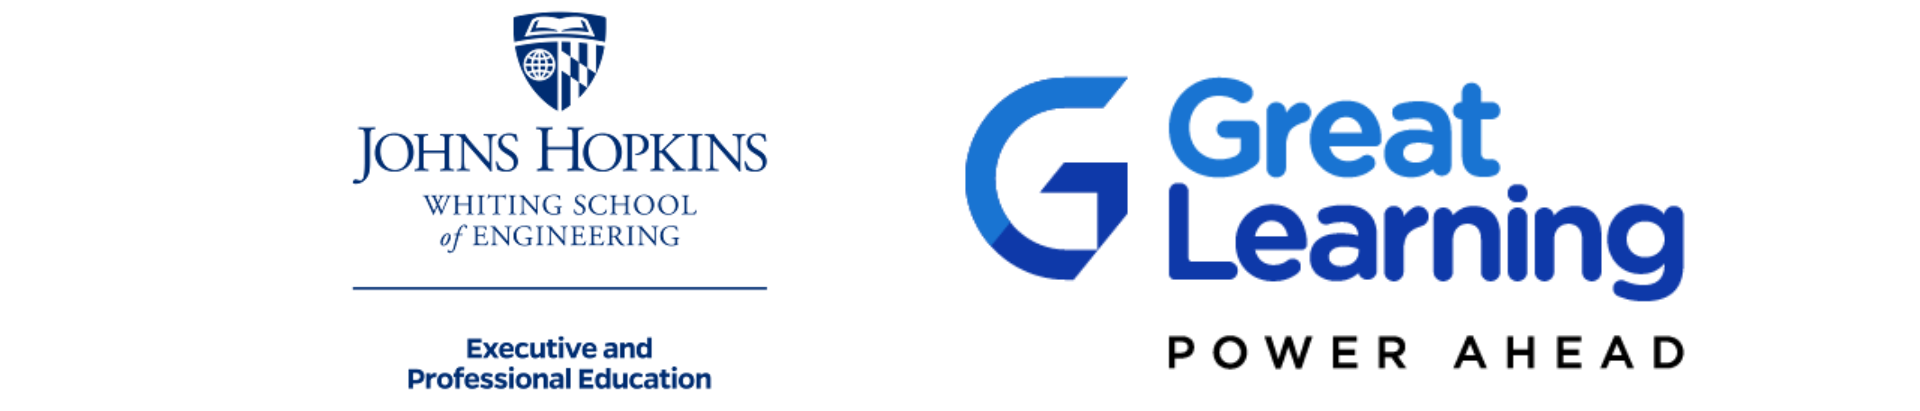

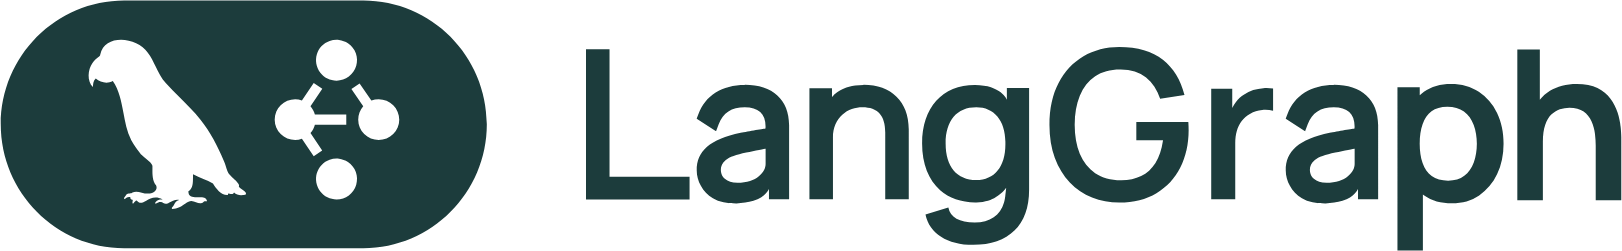

# **The need of LangGraph**



In the early days of LangChain, crafting AI workflows was elegantly simple: a single prompt fed into a large language model (LLM) delivered a clear answer. It was a clean, linear process—perfect for straightforward tasks. But as ambitions grew, so did complexity. What happens when you juggle multiple LLMs, each with distinct roles? Or when your workflow demands conditional splits, branching paths, and intricate logic? Suddenly, chaining becomes a tangle of manual orchestration, prone to errors and inefficiencies.
Enter **LangGraph**, a game-changer that transforms chaotic chains into structured, dynamic graphs, empowering developers to build sophisticated agent-based systems with ease.


## **Why LangGraph?**



**LangGraph** is a package, built on top of **LangChain**, for building and managing AI agents and agent workflows.

LangGraph provides **prebuilt components** to build **agent-based systems** quickly and reliably. Instead of juggling chains, you get a **graph of agents** that can think, use tools, remember context, and even pause for human feedback — all in a clear, structured workflow.

Each agent can:

- Choose the right LLM for the task  
- Use tools as needed  
- Remember past interactions  
- Pause for human feedback  
- Follow complex branching logic


## **Key Features**

- **Memory**: Short-term (session) and long-term (persistent across sessions)  
- **Human-in-the-loop**: Pause for approvals, corrections, or guidance  
- **Streaming**: Real-time output from model, tools, or agent state  
- **Deployment**: Test, debug, and deploy without extra infrastructure  
- **Studio**: Visual IDE to inspect and debug workflows  

# **Key Concepts of LangGraph**


LangGraph models agent workflows as graphs, with three core components driving its functionality: **State**, **Nodes**, and **Edges**.

These elements work together to create flexible, stateful, and dynamic workflows.

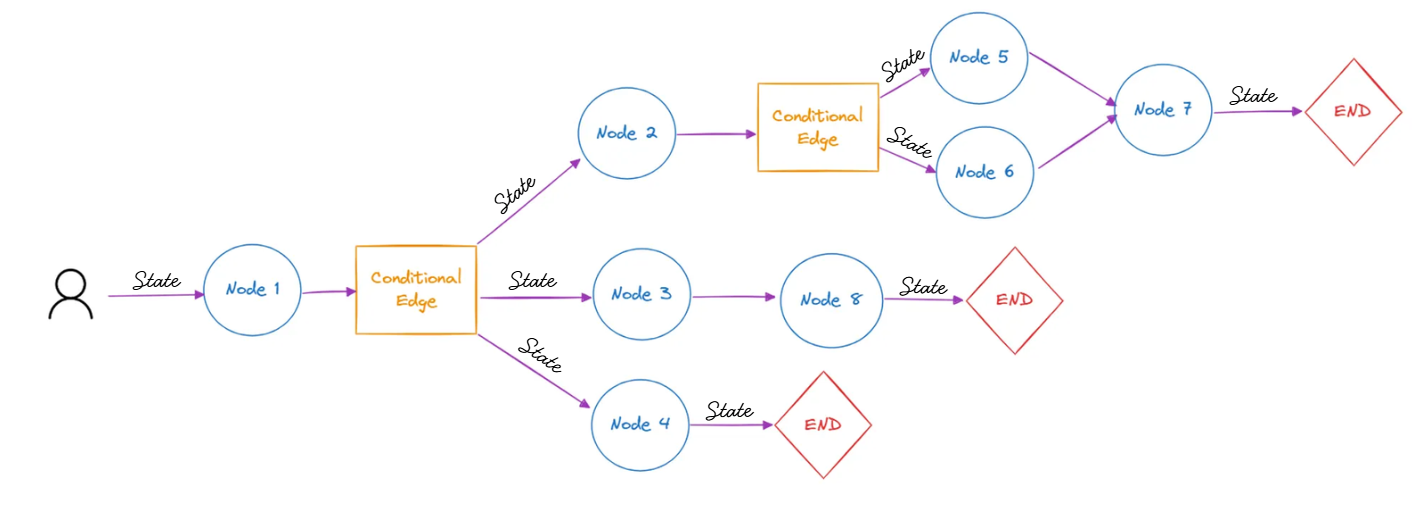

## 1. State

- **Definition**: A shared data structure that captures the current snapshot of the application, typically defined using a schema like a dictionary or model.
- **Role**: Serves as the central hub for all nodes and edges, holding and updating the application's data as nodes process it.
- **Schemas**: Includes a primary schema for the overall state and optional input/output or private schemas for specific node communication.
- **Reducers**: Functions that control how state updates are applied. By default, updates overwrite values, but custom reducers can append or modify data in specific ways.

## 2. Nodes



- **Definition**: Functions that encapsulate the logic of agents, taking the current state as input, performing actions, and returning an updated state.
- **Execution**: Nodes operate in parallel within a single iteration (called a super-step) or sequentially across super-steps, using a message-passing system inspired by Google's Pregel model.
- **Behavior**: Nodes activate when they receive state updates and become inactive when no messages are received, eventually halting the graph when all nodes are inactive.

## 3. Edges




- **Definition**: Functions that determine the next node(s) to execute based on the current state, either through fixed transitions or conditional logic.
- **Types**:
  - **Normal Edges**: Direct transitions from one node to another.
  - **Conditional Edges**: Use logic to decide the next node(s) dynamically.
  - **Entry/Exit Points**: Special nodes like START and END define where the graph begins and ends.
- **Parallel Execution**: Multiple outgoing edges from a node trigger parallel execution of destination nodes in the next super-step.

**Note:**  
Compilation is a mandatory step before executing the graph.  
It ensures the structure is validated and all runtime configurations, such as checkpoints, are properly set up.


# **Why It Matters**

LangGraph’s graph-based approach, with robust state management, modular nodes, and flexible edges, enables the creation of complex, looping workflows. Its message-passing and super-step execution provide a powerful framework for building dynamic, stateful applications, such as multi-agent systems or conversational AI, with precise control over state updates and execution flow.

# Install and Import the Dependencies

In [1]:
!pip install langchain==0.3.27 \
                langchain-core==0.3.79 \
                langgraph==0.6.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 11.3 MB/s eta 0:00:00


# 0. Example: Structuring the Components

##0.1 Defining State for the Graph
---
In LangGraph, **state** can be a `TypedDict`, `Pydantic` model, or `dataclass`. We'll use `TypedDict` for this example. By default, the graph's input and output schema match the state.  

- **TypedDict** – Used to define the exact structure of a dictionary, specifying expected keys and their value types at runtime for safer access.  
  ```python
  from typing import TypedDict  
  
  class State(TypedDict):  
      messages: list[str]  
      counter: int
  ```
- **Pydantic** – A data validation class that enforces types and provides automatic parsing and error handling based on Python type hints.
- **BaseModel** – BaseModel in Pydantic is the base class for creating data models that validate and parse data using Python type hints.
It automatically enforces types, converts compatible data, and provides easy serialization/deserialization.
  ```python
  from pydantic import BaseModel  
  
  class State(BaseModel):  
      messages: list[str]  
      counter: int  
  ```
- **dataclass** – A lightweight way to create classes that automatically generate common methods (`__init__`, `__repr__`, etc.) for holding structured data.  
  ```python
  from dataclasses import dataclass  
  
  @dataclass  
  class State:  
      messages: list[str]  
      counter: int  
  ```

Here's a simple example: we track a list of messages and an extra integer field using `TypedDict`:



In [1]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

##0.2 Defining a node for our BasicGraph
This node function takes the current state, appends a new AIMessage to the messages list, and updates an additional field. It shows how to read and modify state within a LangGraph node.

In [2]:
from langchain_core.messages import AIMessage

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")
    return {"messages": messages + [new_message], "extra_field": 10}

##0.3 Compiling our BasicGraph from the `State` and `Node Components`
Let's next define a simple graph containing this node. We use StateGraph to define a graph that operates on this state. We then use add_node populate our graph.

In [3]:
from langgraph.graph import StateGraph

builder = StateGraph(State)
builder.add_node(node)
builder.set_entry_point("node")
graph = builder.compile()

##0.4 Let's visualize how our graph looks
We are using IPython's `display` and `Image` to render the LangGraph graph as a PNG. The `draw_mermaid_png()` method generates a visual representation of the graph, which we can display directly in a Jupyter notebook.

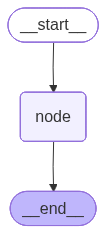

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Although this simple example could also be done with LangChain, LangGraph becomes essential as workflows grow more complex. What looks simple here, a single node updating state, soon scales into graphs with multiple nodes, branching logic, and conditional flows. In the next examples, we will explore more intricate graphs that show why LangGraph is needed.


##0.5 Invoking the Chain
The flow of this invocation represents a simple state update in the graph:

1. The node receives the current state, which contains a list of messages and an extra field.  
2. The node reads the messages, which already include a `HumanMessage("Hi")`.  
3. It appends a new `AIMessage("Hello!")` to the messages list.  
4. It updates the `extra_field` to 10.  
5. The resulting state now contains both messages and the updated extra field, ready for further processing or the next node.


In [5]:
from langchain_core.messages import HumanMessage

result = graph.invoke({"messages": [HumanMessage("Hi")]})
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 10}

Note that:

- The invocation was triggered by updating a single key in the state.  
- The result of the invocation returns the **entire updated state**.  
- For convenience, we often inspect the contents of message objects using **pretty-print**.


In [6]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


# **Moving Beyond States, Nodes, and Edges**


While **States**, **Nodes**, and **Edges** form the structural foundation of LangGraph, the true power of the framework lies in its advanced feature ecosystem — designed to make AI workflows flexible, persistent, intelligent, and human-aware.  
These capabilities elevate LangGraph from a simple graph execution model to a robust orchestration engine for complex, stateful, and adaptive applications.



## **Workflows vs Agents**



### Workflows
Workflows are structured systems with predetermined code paths, designed to operate in a specific order. Key methods include:
- **Prompt Chaining**: Sequentially processes tasks through LLM calls (In → LLM call → Out).
- **Parallelization**: Distributes tasks across multiple LLMs simultaneously (In → Multiple LLMs → Out).
- **Routing**: Directs input to the appropriate LLM based on predefined logic (In → Router → LLM → Out).
- **Evaluator-Optimizer**: Involves a generator and optimizer, with the LLM guiding control flow through established code paths (In → Generator → Optimizer → Out).
These workflows ensure consistency and predictability.

### Agents
Agents are dynamic entities that define their own processes and tool usage based on environmental feedback. The process includes:
- Input is processed through an LLM call to determine an action.
- The action is executed using a tool to produce an output (In → LLM call → Action → Tool → Out).
- A feedback loop allows the agent to adapt and refine its actions autonomously.
Unlike workflows, agents offer flexibility and responsiveness to changing conditions.

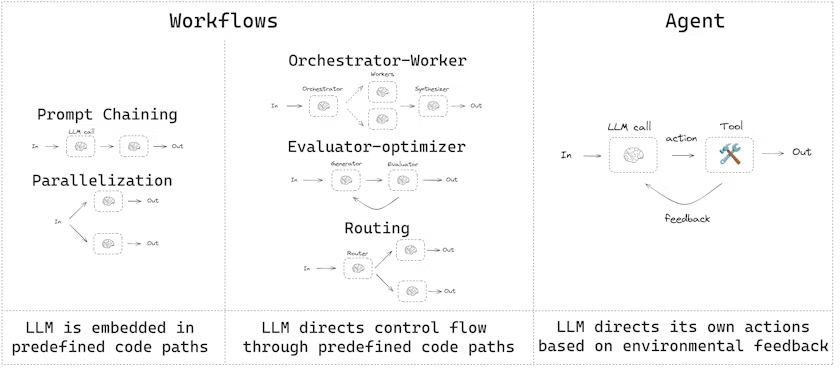

## **Branching Types in Workflows**



### Sequential
- Tasks are executed one after another in a predefined order.
- Example: Prompt Chaining (In → LLM call → Out).

### Conditional
- Execution path depends on specific conditions or evaluations.
- Example: Routing (In → Router → LLM → Out), where the router decides the next step based on input.

### Parallel
- Multiple tasks are processed simultaneously to improve efficiency.
- Example: Parallelization (In → Multiple LLMs → Out).

### Supervisor (Orchestrator)
- Oversees and coordinates multiple workers or processes.
- Example: Orchestrator-Worker (In → Orchestrator → Workers → Synthesizer → Out), managing the flow and synthesis of results.